# Programming your own convolutional network

Today's lab will use a common dataset called [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to let us practice making a convolutional neural network for classification.  This dataset consists of 60,000 32x32 color pictures, each of which map to one of ten classes.  To do this, we'll use Pytorch's built-in CIFAR10 Dataset, so we won't need to program our own.

The two cells below handle imports, and then build the training and testing Datasets.  The first time you run these, it will actually download the data for you.  Notice there are some transformations listed - you're welcome to add to these (and perhaps should), but you'll need at least these, which turn the image file into a Pytorch Image, and then convert them to 32-bit floats.

The end of the second cell prints out the labels, just so we can see it's working.

In [65]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

In [86]:
# prepare training transform (uses random horizontal flips and random rotations for data augmentation)
train_transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=15),
    v2.ToDtype(torch.float32, scale=True)
])

# prepare testing transforms (no data augmentation)
test_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

# load datasets with transforms
trainSet = CIFAR10('./datasets', train=True, transform=train_transforms, download=True)
testSet = CIFAR10('./datasets', train=False, transform=test_transforms)

Files already downloaded and verified


In [68]:
# create dataloaders for grabbing batches one at a time
trainLoader = DataLoader(trainSet, batch_size=100, shuffle=True, num_workers=4)
testLoader = DataLoader(testSet, batch_size=100, shuffle=False, num_workers=4)

In [69]:
# trains the given model on the CIFAR10 dataset
# model = the model that should be trained
# lr = learning rate
# epochs = number of epochs to perform
# criterion = loss function to train with
def trainModel(model, lr, epochs, criterion):

    # move model to GPU
    model = model.to('cuda')

    # define optimizer function to be Adam (with given learning rate)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # keep track of best testing loss to always save best model
    best_test_loss = -1

    # loop through all epochs
    for epoch in range(epochs):

        # define total loss for all batches
        total_loss = 0

        # loop through all batches in training set
        for X, y in trainLoader:

            # move images and correct labels to GPU
            X = X.to('cuda')
            y = y.to('cuda')

            # get predictions from model
            predictions = model(X)

            # calculate loss of model
            loss = criterion(predictions, y)

            # use Adam to adjust weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update total loss
            total_loss += loss.item()

        # calculate testing loss
        test_loss = 0
        with torch.no_grad():

            # loop through testing batches
            for X, y in testLoader:

                # move images and correct labels to GPU
                X = X.to('cuda')
                y = y.to('cuda')

                # get predictions from model
                pred = model(X)
                
                # update testing loss
                test_loss += criterion(pred, y).item()

            # get final testing loss
            test_loss /= len(testLoader)

            # save model if it achieved a better testing loss than previous best
            if test_loss < best_test_loss or best_test_loss == -1:
                torch.save(model, 'bestModel')
                best_test_loss = test_loss

    # return best model
    return torch.load('bestModel')

For creating the following model, I found [this](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130) page and took a look at [this](http://arxiv.org/pdf/1412.6806) research paper. I learned about replacing pooling layers of 2 with kernels of stride 2 as well as the Global Average Pooling. I then created the neural network with these structural design choices in mind (with some help from ChatGPT on how to implement them). I started with two convolutional layers per sequence, in a more similar manner to the exact proposed design used in the paper. However, with 3 overall layers, that design ended up being quite awful. It only achieved a testing accuracy of 0.1, and I figured it was due to the overly complex nature of the model. Thus, I decided to only use one convolutional layer per sequence, which ended up being the best choice - this is the final model, with a testing accuracy of 0.81.

In [70]:
# define the convolutional neural network
class CNN(nn.Module):

    # define the layers
    def __init__(self):
        super(CNN, self).__init__()

        # first (convolutional) layer
        self.conv1 = nn.Sequential( # input: 3x32x32
            nn.Conv2d(3, 32, 3, 1, 1),
            #nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 2, 0)
        ) # output: 32x16x16

        # second (convolutional) layer
        self.conv2 = nn.Sequential( # input: 32x16x16
            nn.Conv2d(32, 64, 3, 1, 1),
            #nn.Conv2d(64, 64, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 2, 0),
        ) # output: 64x8x8

        # third (convolutional) layer
        self.conv3 = nn.Sequential( # input: 64x8x8
            nn.Conv2d(64, 128, 3, 1, 1),
            #nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 2, 0),
        ) # output: 128x4x4

        # global average pooling layer
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # linear layer with 128 inputs (from GAP layer) and 10 outputs (for each class)
        self.fc = nn.Linear(128, 10)

    # define forward pass with all layers applied sequentially
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [71]:
# train CNN
finalModel = trainModel(CNN(), 0.001, 100, nn.CrossEntropyLoss())

In [72]:
# retrieve accuracy (percentages) for training and testing data using a given model
# model = given model
# data = dataloader of data
def getAccuracy(model, data):

    # counters for final calculation
    total = correct = 0

    # set the model to evaluation mode
    model.eval()

    # test model without any gradient calculations
    with torch.no_grad():

        # loop through dataloader
        for X, y in data:

            # move images and correct labels to GPU
            X = X.to('cuda')
            y = y.to('cuda')

            # get predictions from model
            preds = torch.max(model(X), 1)[1]

            # update counters
            total += y.size(0)
            correct += (preds == y).sum().item()

    # return accuracy
    return correct/total

In [73]:
# print accuracy for base model
print(f'Testing Accuracy: {getAccuracy(finalModel, testLoader)}')

Testing Accuracy: 0.8103


At this point, I felt that the network itself was fairly robust. However, doing some hyperparameter search couldn't hurt. So, I just tested various (quasi-)logarithmic values of the learning rate, and kept track of the testing error after running through **100** epochs for each value.

In [80]:
# plot testing accuracy for given learning rates
# returns list of models for each learning rate
def testLR(values, epochs):
    
    # lists to store accuracies and models
    accuracies = []
    models = []

    # loop through all learning rates
    for lr in values:

        # get the trained model
        bestModel = trainModel(CNN(), lr, epochs, nn.CrossEntropyLoss())

        # add it to the list
        models.append(bestModel)

        # get accuracy and add to list
        accuracies.append(getAccuracy(bestModel, testLoader))

    # plot learning rate vs accuracy
    plt.plot(values, accuracies)
    plt.xscale("log")
    plt.xlabel("Learning Rate")
    plt.ylabel("Testing Accuracy")
    plt.show()

    # return models
    return models

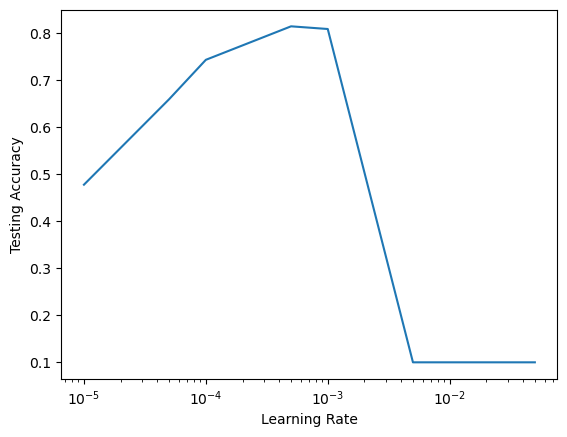

In [82]:
# test logarithmic learning rates, plot results and save all models to list
logModels = testLR([0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05], 100)

Based on this test, a learning rate between `0.0005` and `0.001` seems to be the sweet spot, so now I will test values between those two learning rates to dial in on a specifically apt value to use.

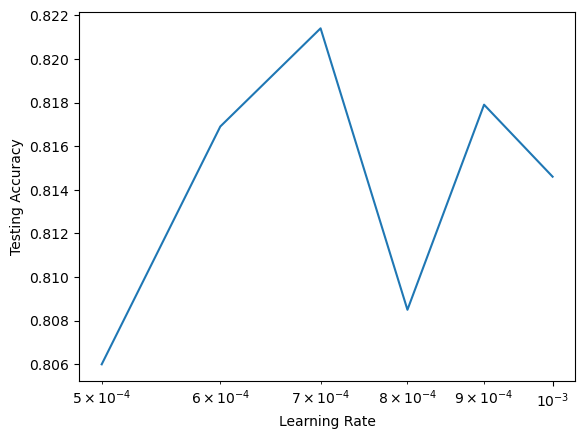

In [83]:
# test learning rates between 0.0005 and 0.001, plot results and save all models to list
linModels = testLR([0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001], 100)

Looks like `0.0007` yielded the best testing accuracy, at just below 0.822. I will go ahead and save that model and conclude the lab with that as my final product.

In [84]:
# save the best model (lr of 0.0007)
finalModel = linModels[2]

# make sure the testing accuracy is still correct
print(getAccuracy(finalModel, testLoader))

0.8214


In [85]:
# save the model to the drive
torch.save(finalModel, 'finalModel')